In [46]:
import os
import random
from scipy import io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [47]:
len(os.listdir('../../data/images'))

24984

In [114]:
f = open('../../data/mpii_annotations.json', encoding='UTF-8')
raw_data = json.loads(f.read())
f.close()

In [120]:
raw_data[0]['img_paths']

'015601864.jpg'

In [126]:
np.array(raw_data[0]['joint_self'])[:,0]

array([620.  , 616.  , 573.  , 647.  , 661.  , 656.  , 610.  , 647.  ,
       637.02, 695.98, 606.  , 553.  , 601.  , 692.  , 693.  , 688.  ])

In [129]:
raw_data[0]['joint_others']

[[895.0, 293.0, 1.0],
 [910.0, 279.0, 1.0],
 [945.0, 223.0, 0.0],
 [1012.0, 218.0, 1.0],
 [961.0, 315.0, 1.0],
 [960.0, 403.0, 1.0],
 [979.0, 221.0, 0.0],
 [906.0, 190.0, 0.0],
 [912.491, 190.659, 1.0],
 [830.509, 182.341, 1.0],
 [871.0, 304.0, 1.0],
 [883.0, 229.0, 1.0],
 [888.0, 174.0, 0.0],
 [924.0, 206.0, 1.0],
 [1013.0, 203.0, 1.0],
 [955.0, 263.0, 1.0]]

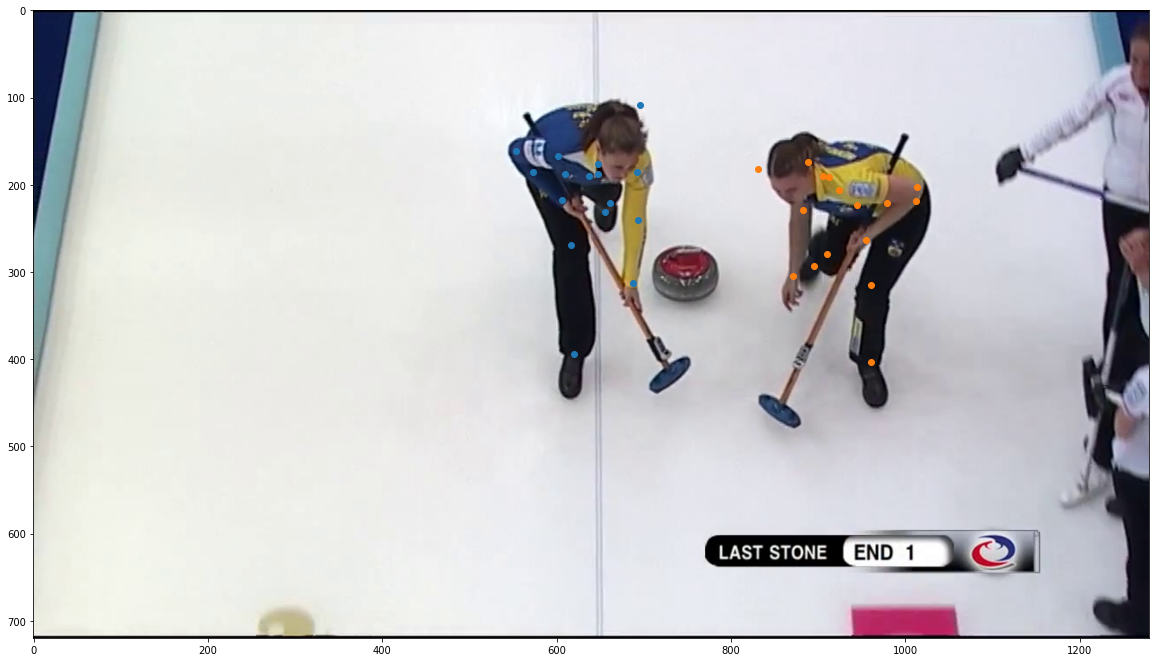

In [130]:
image = Image.open('../../data/images/015601864.jpg')
fig = plt.figure(figsize=(20,15))
plt.scatter(np.array(raw_data[0]['joint_self'])[:,0], np.array(raw_data[0]['joint_self'])[:,1])
plt.scatter(np.array(raw_data[0]['joint_others'])[:,0], np.array(raw_data[0]['joint_others'])[:,1])
plt.imshow(image)

In [78]:
mat_file = io.loadmat('../../data/annotation/mpii_human_pose_v1_u12_1.mat')

image = Image.open('../../data/images/037454012.jpg')
np.shape(image)

(720, 1280, 3)

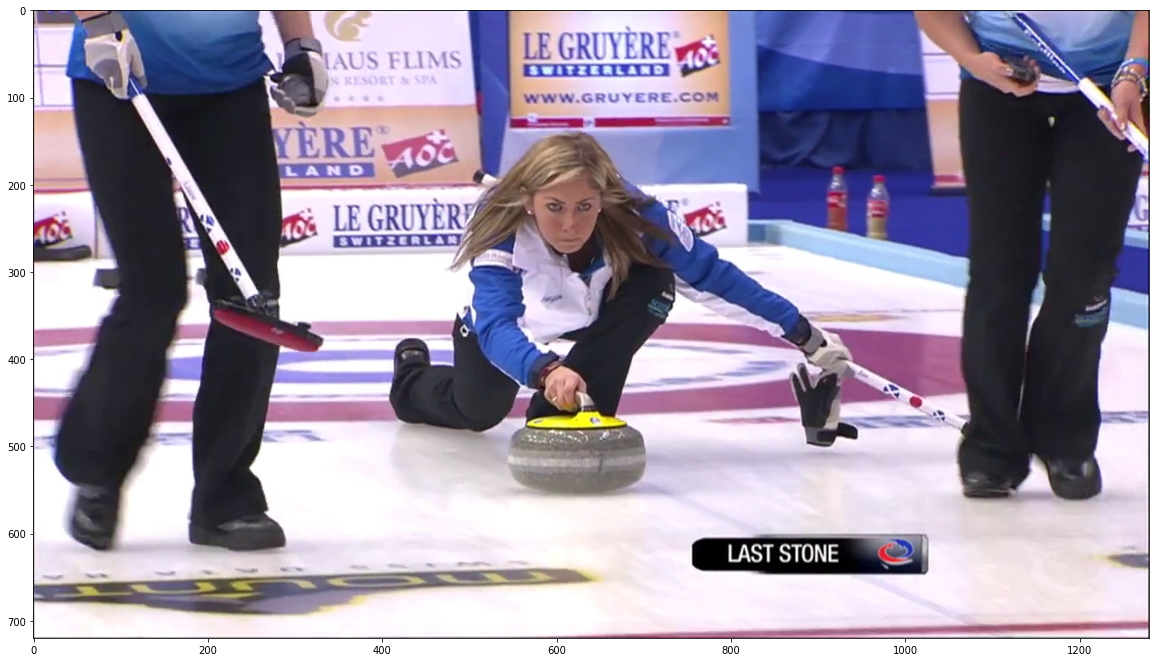

In [79]:
fig = plt.figure(figsize=(20,15))
plt.imshow(image)

In [53]:
mat_file['RELEASE'][0][0][0][0][0]

(array([[(array(['037454012.jpg'], dtype='<U13'),)]], dtype=[('name', 'O')]), array([[(array([[3.88073395]]), array([[(array([[601]], dtype=uint16), array([[380]], dtype=uint16))]],
      dtype=[('x', 'O'), ('y', 'O')]))]],
      dtype=[('scale', 'O'), ('objpos', 'O')]), array([], shape=(1, 0), dtype=float64), array([], shape=(1, 0), dtype=float64))

In [84]:
mat_file['RELEASE'][0][0][0][0][0][0] #image name

array([[(array(['037454012.jpg'], dtype='<U13'),)]], dtype=[('name', 'O')])

In [85]:
mat_file['RELEASE'][0][0][0][0][0][1]

#coordinates of the head rectangle
#scale: person scale w.r.t. 200 px height
#objops: rough human position in the image

array([[(array([[3.88073395]]), array([[(array([[601]], dtype=uint16), array([[380]], dtype=uint16))]],
      dtype=[('x', 'O'), ('y', 'O')]))]],
      dtype=[('scale', 'O'), ('objpos', 'O')])

In [86]:
mat_file['RELEASE'][0][0][0][0][0][2] #annotation points

array([], shape=(1, 0), dtype=float64)

In [88]:
mat_file['RELEASE'][0][0][0][0][0][3]

array([], shape=(1, 0), dtype=float64)

In [107]:
import gzip
import json
import os
import random

import numpy as np
import torch
import torch.utils.data as data
from importlib_resources import open_binary
from scipy.io import loadmat
from tabulate import tabulate

In [ ]:
class Mpii(data.Dataset):
    DATA_INFO = DataInfo(
        rgb_mean=[0.4404, 0.4440, 0.4327],
        rgb_stddev=[0.2458, 0.2410, 0.2468],
        joint_names=MPII_JOINT_NAMES,
        hflip_indices=[5, 4, 3, 2, 1, 0, 6, 7, 8, 9, 15, 14, 13, 12, 11, 10],
    )

    # Suggested joints to use for average PCK calculations.
    ACC_JOINTS = [0, 1, 2, 3, 4, 5, 10, 11, 14, 15]

    # The ratio between input spatial resolution vs. output heatmap spatial resolution
    INPUT_OUTPUT_RATIO = 4

    def __init__(self, image_path, is_train=True, inp_res=256, sigma=1, scale_factor=0.25,
                 rot_factor=30, label_type='Gaussian'):
        self.img_folder = image_path # root image folders
        self.is_train = is_train # training set or test set
        if not isinstance(inp_res, (list, tuple)):  # Input res stored as (H, W)
            self.inp_res = [inp_res, inp_res]
        else:
            self.inp_res = inp_res
        self.out_res = [int(self.inp_res[0] / self.INPUT_OUTPUT_RATIO),
                        int(self.inp_res[1] / self.INPUT_OUTPUT_RATIO)]
        self.sigma = sigma
        self.scale_factor = scale_factor
        self.rot_factor = rot_factor
        self.label_type = label_type

        # create train/val split

        with gzip.open(open_binary(stacked_hourglass.res, 'mpii_annotations.json.gz')) as f:
            self.anno = json.load(f)

        self.train_list, self.valid_list = [], []
        for idx, val in enumerate(self.anno):
            if val['isValidation'] == True:
                self.valid_list.append(idx)
            else:
                self.train_list.append(idx)

    def __getitem__(self, index):
        sf = self.scale_factor
        rf = self.rot_factor
        if self.is_train:
            a = self.anno[self.train_list[index]]
        else:
            a = self.anno[self.valid_list[index]]

        img_path = os.path.join(self.img_folder, a['img_paths'])
        pts = torch.Tensor(a['joint_self'])
        # pts[:, 0:2] -= 1  # Convert pts to zero based

        # c = torch.Tensor(a['objpos']) - 1
        c = torch.Tensor(a['objpos'])
        s = a['scale_provided']

        # Adjust center/scale slightly to avoid cropping limbs
        if c[0] != -1:
            c[1] = c[1] + 15 * s
            s = s * 1.25

        # For single-person pose estimation with a centered/scaled figure
        nparts = pts.size(0)
        img = load_image(img_path)  # CxHxW

        r = 0
        if self.is_train:
            s = s*torch.randn(1).mul_(sf).add_(1).clamp(1-sf, 1+sf)[0]
            r = torch.randn(1).mul_(rf).clamp(-2*rf, 2*rf)[0] if random.random() <= 0.6 else 0

            # Flip
            if random.random() <= 0.5:
                img = fliplr(img)
                pts = shufflelr(pts, img.size(2), self.DATA_INFO.hflip_indices)
                c[0] = img.size(2) - c[0]

            # Color
            img[0, :, :].mul_(random.uniform(0.8, 1.2)).clamp_(0, 1)
            img[1, :, :].mul_(random.uniform(0.8, 1.2)).clamp_(0, 1)
            img[2, :, :].mul_(random.uniform(0.8, 1.2)).clamp_(0, 1)

        # Prepare image and groundtruth map
        inp = crop(img, c, s, self.inp_res, rot=r)
        inp = color_normalize(inp, self.DATA_INFO.rgb_mean, self.DATA_INFO.rgb_stddev)

        # Generate ground truth
        tpts = pts.clone()
        target = torch.zeros(nparts, *self.out_res)
        target_weight = tpts[:, 2].clone().view(nparts, 1)

        for i in range(nparts):
            # if tpts[i, 2] > 0: # This is evil!!
            if tpts[i, 1] > 0:
                tpts[i, 0:2] = to_torch(transform(tpts[i, 0:2]+1, c, s, self.out_res, rot=r))
                target[i], vis = draw_labelmap(target[i], tpts[i]-1, self.sigma, type=self.label_type)
                target_weight[i, 0] *= vis

        # Meta info
        if not isinstance(s, torch.Tensor):
            s = torch.Tensor(s)

        meta = {'index' : index, 'center' : c, 'scale' : s,
        'pts' : pts, 'tpts' : tpts, 'target_weight': target_weight}

        return inp, target, meta

    def __len__(self):
        if self.is_train:
            return len(self.train_list)
        else:
            return len(self.valid_list)